In [1]:
import numpy as np

import matplotlib.pyplot as plt
import matplotlib
%matplotlib notebook
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
font = {'weight' : 'medium',
       'size'   : 13}
matplotlib.rc('font', **font)

from mpl_toolkits import mplot3d

from numba import njit, float64, vectorize


from csr2d.wake import green_mesh,  boundary_convolve
#from csr2d.convolution import fftconvolve2

import time

import concurrent.futures as cf

import scipy.constants
mec2 = scipy.constants.value('electron mass energy equivalent in MeV')*1e6
c_light = scipy.constants.c
e_charge = scipy.constants.e
r_e = scipy.constants.value('classical electron radius')

In [2]:
# Chris's parameters 
gamma = 500
rho = 1.0 # Bend radius in m

# Total charge
#Nb = 6.25e9
#Q = e_charge * Nb

## Additional parameters
beta = (1-1/gamma**2)**(1/2)
mc2 = 510998.950
p0c = gamma * beta * mc2  # in eV

sigma_x  = 10e-6
sigma_z  = 10e-6
# Bypassing the beam, use smooth Gaussian distribution

def lamb_2d(z,x):
    return 1/(2*np.pi*sigma_x*sigma_z)* np.exp(-z**2 / 2 / sigma_z**2 - x**2 / 2 / sigma_x**2)
def lamb_2d_prime(z,x):
    return 1/(2*np.pi*sigma_x*sigma_z)* np.exp(-z**2 / 2 / sigma_z**2 - x**2 / 2 / sigma_x**2) * (-z / sigma_z**2)

nz = 256
nx = 256
zvec = np.linspace(-5*sigma_z, 5*sigma_z, nz)
xvec = np.linspace(-5*sigma_x, 5*sigma_x, nx)
Z, X = np.meshgrid(zvec, xvec, indexing='ij')
lambda_grid_filtered = lamb_2d(Z,X)
lambda_grid_filtered_prime = lamb_2d_prime(Z,X)
dz = (10*sigma_z) / (nz - 1)
dx = (10*sigma_x) / (nx - 1)

In [9]:
phi = 0.08
Es_case_A_grid = green_mesh((nz, nx), (dz, dx), rho=rho, gamma=gamma, component= 'Es_case_A', phi = phi)
Es_case_B_grid_IGF = green_mesh((nz, nx), (dz, dx), rho=rho, gamma=gamma, component= 'Es_case_B_IGF')

component: Es_case_A
Change to internal coordinates...
component: Es_case_B_IGF
Change to internal coordinates...
Finding IGF for 3584 points...
Done. Starting midpoint method...


In [17]:
#@njit
def boundary_convolve_Ws_A_super(z_observe, x_observe):
    return boundary_convolve('A', z_observe, x_observe, zvec, xvec, dz, dx, lambda_grid_filtered, Es_case_A_grid,  gamma=gamma, rho=rho, phi=phi)

def boundary_convolve_Ws_B_super(z_observe, x_observe):
    return boundary_convolve('B', z_observe, x_observe, zvec, xvec, dz, dx, lambda_grid_filtered, Es_case_B_grid_IGF,  gamma=gamma, rho=rho, phi=phi)

In [ ]:
factor = (1/gamma**2 / rho**2)

factor = (beta**2 / rho**2)

In [8]:
boundary_convolve_Ws_A_super(0,0)

100641514959.50288

In [18]:
with cf.ProcessPoolExecutor(max_workers=32) as executor:
    t1 = time.time()
    temp = np.array(list(executor.map(boundary_convolve_Ws_A_super, Z.flatten(), X.flatten())))
    Ws_grid_case_A = temp.reshape(Z.shape)
    t2 = time.time()
print('This takes,', t2-t1, 's')

This takes, 52.80760478973389 s


In [19]:
with cf.ProcessPoolExecutor(max_workers=32) as executor:
    t1 = time.time()
    temp = np.array(list(executor.map(boundary_convolve_Ws_B_super, Z.flatten(), X.flatten())))
    Ws_grid_case_B = temp.reshape(Z.shape)
    t2 = time.time()
print('This takes,', t2-t1, 's')

This takes, 54.53923678398132 s


Text(0.5, 0.92, 'psi_s at the first step of chicane')

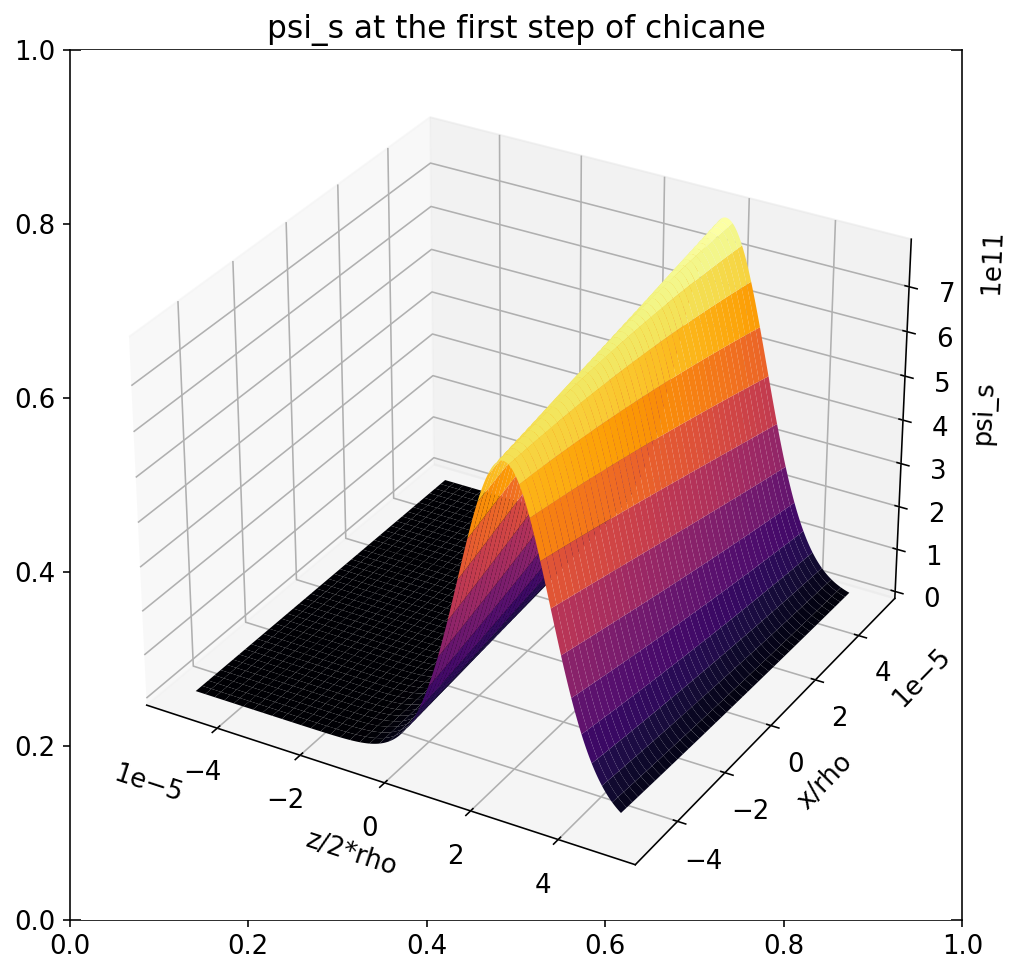

In [13]:
fig, ax = plt.subplots(figsize=(8,8))
ax = plt.axes(projection='3d')

ax.plot_surface(Z,X, Ws_grid_case_A , cmap='inferno')
ax.set_xlabel('z/2*rho')
ax.set_ylabel('x/rho')
ax.set_zlabel('psi_s')
ax.set_title('psi_s at the first step of chicane')

Text(0.5, 0.92, 'psi_s at the first step of chicane')

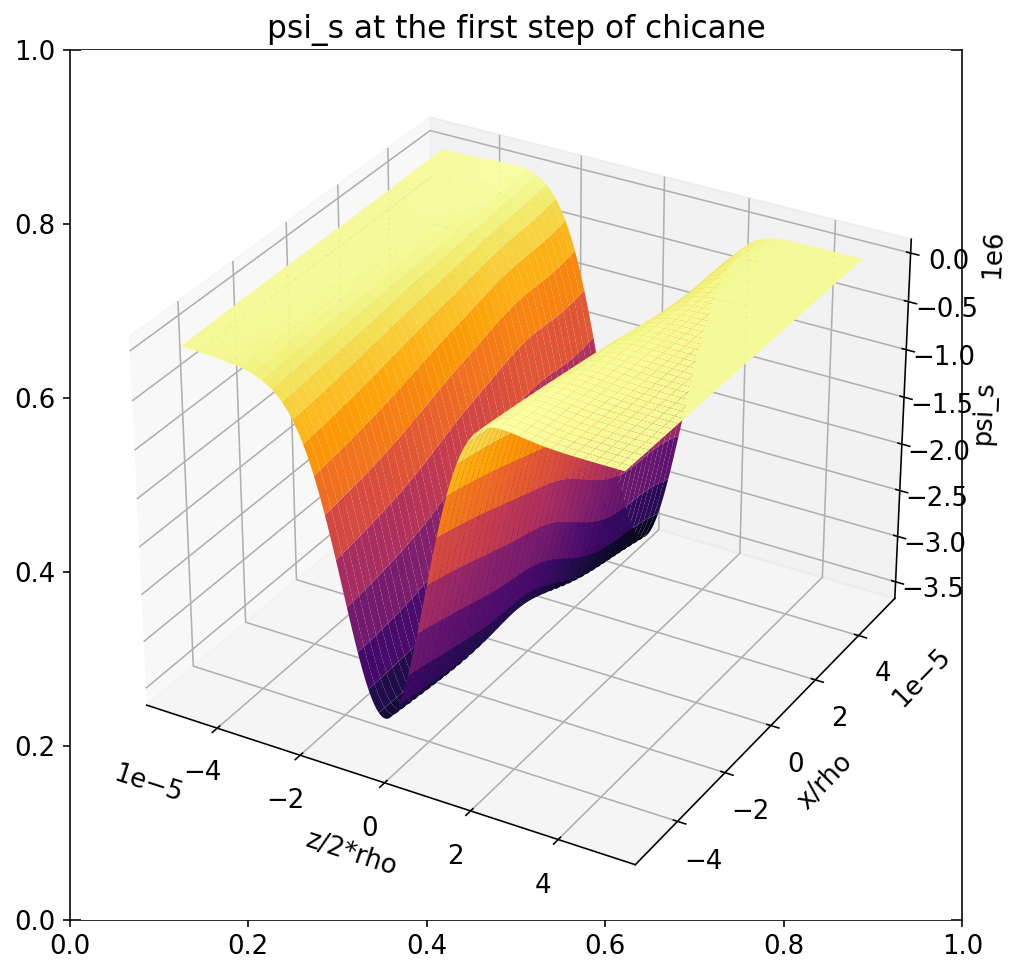

In [14]:
fig, ax = plt.subplots(figsize=(8,8))
ax = plt.axes(projection='3d')

ax.plot_surface(Z,X, Ws_grid_case_B , cmap='inferno')
ax.set_xlabel('z/2*rho')
ax.set_ylabel('x/rho')
ax.set_zlabel('psi_s')
ax.set_title('psi_s at the first step of chicane')

In [33]:
from numba import char

In [3]:
from csr2d.deposit import histogram_cic_2d
from scipy.signal import savgol_filter
from scipy.interpolate import RectBivariateSpline
from csr2d.convolution import fftconvolve2
from scipy.ndimage import map_coordinates

def csr2d_kick_calc(
    z_b,
    x_b,
    weight,
    *,
    gamma=None,
    rho=None,
    phi=None,
    steady_state=False,
    nz=100,
    nx=100,
    xlim=None,
    zlim=None,
    map_f=map,
    species="electron",
    imethod='map_coordinates',
    debug=False,
):
    """
    Calculates the 2D CSR kick on a set of particles with positions `z_b`, `x_b` and charges `charges`.
    
    Parameters
    ----------
    z_b : np.array
        Bunch z coordinates in [m]

    x_b : np.array
        Bunch x coordinates in [m]
  
    weight : np.array
        weight array (positive only) in [C]
        This should sum to the total charge in the bunch
        
    gamma : float
        Relativistic gamma
        
    rho : float
        bending radius in [m]
        
    phi : float
        entrance angle in radian
        
    nz : int
        number of z grid points
        
    nx : int
        number of x grid points     
        
    steady_state : boolean
        If True, the transient terms in case A and B are ignored
    
    zlim : floats (min, max) or None
        z grid limits in [m]
        
    xlim : floats (min, max) or None  
        x grid limits in [m]
        
    map_f : map function for creating potential grids.
            Examples:
                map (default)
                executor.map
    
    species : str
        Particle species. Currently required to be 'electron'
        
    imethod : str
        Interpolation method for kicks. Must be one of:
            'map_coordinates' (default): uses  scipy.ndimage.map_coordinates 
            'spline': uses: scipy.interpolate.RectBivariateSpline
    
    debug: bool
        If True, returns the computational grids. 
        Default: False
        
              
    Returns
    -------
    dict with:
    
        ddelta_ds : np.array
            relative z momentum kick [1/m]
            
        dxp_ds : np.array
            relative x momentum kick [1/m]
    """
    assert species == "electron", "TODO: support species {species}"
    # assert np.sign(rho) == 1, 'TODO: negative rho'

    # Grid setup
    if zlim:
        zmin = zlim[0]
        zmax = zlim[1]
    else:
        zmin = z_b.min()
        zmax = z_b.max()

    if xlim:
        xmin = xlim[0]
        xmax = xlim[1]
    else:
        xmin = x_b.min()
        xmax = x_b.max()

    dz = (zmax - zmin) / (nz - 1)
    dx = (xmax - xmin) / (nx - 1)

    # Charge deposition
    t1 = time.time()
    charge_grid = histogram_cic_2d(z_b, x_b, weight, nz, zmin, zmax, nx, xmin, xmax)

    if debug:
        t2 = time.time()
        print("Depositing particles takes:", t2 - t1, "s")

    # Normalize the grid so its integral is unity
    norm = np.sum(charge_grid) * dz * dx
    lambda_grid = charge_grid / norm

    # Apply savgol filter to the distribution grid
    lambda_grid_filtered = np.array([savgol_filter(lambda_grid[:, i], 13, 2) for i in np.arange(nx)]).T
    
    # Differentiation in z 
    #lambda_grid_filtered_prime = central_difference_z(lambda_grid_filtered, nz, nx, dz, order=1)

    # Distribution grid axis vectors
    zvec = np.linspace(zmin, zmax, nz)
    xvec = np.linspace(xmin, xmax, nx)
    Z, X = np.meshgrid(zvec, xvec, indexing='ij')

    beta = np.sqrt(1 - 1/gamma**2)

    t3 = time.time()

    Es_case_B_grid_IGF = green_mesh((nz, nx), (dz, dx), rho=rho, gamma=gamma, component= 'Es_case_B_IGF')
    Fx_case_B_grid_IGF = green_mesh((nz, nx), (dz, dx), rho=rho, gamma=gamma, component= 'Fx_case_B_IGF')

    if debug:
        t4 = time.time()
        print("Computing case B field grids takes:", t4 - t3, "s")
    
    if steady_state==True:
        
        ### Compute the wake via 2d convolution (no boundary condition)
        #conv_s, conv_x = fftconvolve2(lambda_grid_filtered_prime, psi_s_grid, psi_x_grid)
        conv_s, conv_x = fftconvolve2(lambda_grid_filtered, Es_case_B_grid_IGF, Fx_case_B_grid_IGF)
        
        Ws_grid = (beta ** 2 / abs(rho)) * (conv_s) * (dz * dx)
        Wx_grid = (beta ** 2 / abs(rho)) * (conv_x) * (dz * dx)
        
    else: 
        Es_case_A_grid = green_mesh((nz, nx), (dz, dx), rho=rho, gamma=gamma, component= 'Es_case_A', phi = phi)
        Fx_case_A_grid = green_mesh((nz, nx), (dz, dx), rho=rho, gamma=gamma, component= 'Fx_case_A', phi = phi)
        
        @vectorize([float64(float64, float64)], target='parallel')
        def boundary_convolve_Ws_A_super(z_observe, x_observe):
            return boundary_convolve(1, z_observe, x_observe, zvec, xvec, dz, dx, lambda_grid_filtered, Es_case_A_grid, gamma=gamma, rho=rho, phi=phi)
        @vectorize([float64(float64, float64)], target='parallel')
        def boundary_convolve_Ws_B_super(z_observe, x_observe):
            return boundary_convolve(2, z_observe, x_observe, zvec, xvec, dz, dx, lambda_grid_filtered, Es_case_B_grid_IGF, gamma=gamma, rho=rho, phi=phi)

        @vectorize([float64(float64, float64)], target='parallel')
        def boundary_convolve_Wx_A_super(z_observe, x_observe):
            return boundary_convolve(1, z_observe, x_observe, zvec, xvec, dz, dx, lambda_grid_filtered, Fx_case_A_grid, gamma=gamma, rho=rho, phi=phi)
        @vectorize([float64(float64, float64)], target='parallel')
        def boundary_convolve_Wx_B_super(z_observe, x_observe):
            return boundary_convolve(2, z_observe, x_observe, zvec, xvec, dz, dx, lambda_grid_filtered, Fx_case_B_grid_IGF, gamma=gamma, rho=rho, phi=phi)
        
        #@vectorize([float64(float64, float64, char, float64[:,:])])
        #def boundary_convolve_super(z_observe, x_observe, case, green):
        #    return boundary_convolve(case, z_observe, x_observe, zvec, xvec, dz, dx, lambda_grid_filtered, green, gamma=gamma, rho=rho, phi=phi)        

        if debug:
            print("mappable function defined")
    
        # Use map ( instead of Numba vectorization )
        #temp = np.array(list(map_f(boundary_convolve_Ws_A_super, Z.flatten(), X.flatten())))
        #if debug:
        #    print("temp defined")
        #    #print(temp[0])
        # 
        # Ws_grid_case_A = temp.reshape(Z.shape) * (1/gamma**2/rho**2)* (dz*dx)
        # temp = np.array(list(map_f(boundary_convolve_Ws_B_super, Z.flatten(), X.flatten())))
        # Ws_grid_case_B = temp.reshape(Z.shape) * (beta**2 / rho**2)* (dz*dx)
        # if debug:
        #     print("Grids defined")    

        # use Numba vectorization 
        factor_case_A = (1/gamma**2/rho**2)* (dz*dx)
        Ws_grid_case_A = boundary_convolve_Ws_A_super(Z, X) * factor_case_A
        Wx_grid_case_A = boundary_convolve_Wx_A_super(Z, X) * factor_case_A
        if debug:
            print("Ws_grid_case_A calculated!!")
        factor_case_B = (beta**2 / rho**2)* (dz*dx)
        Ws_grid_case_B = boundary_convolve_Ws_B_super(Z, X) * factor_case_B
        Wx_grid_case_B = boundary_convolve_Wx_B_super(Z, X) * factor_case_B
        if debug:
            print("Ws_grid_case_B calculated!!")

        Ws_grid = Ws_grid_case_B  + Ws_grid_case_A
        Wx_grid = Wx_grid_case_B  + Wx_grid_case_A

    if debug:
        t5 = time.time()
        print("Convolution takes:", t5 - t4, "s")

    
    # Calculate the kicks at the particle locations
    
    # Overall factor
    Nb = np.sum(weight) / e_charge
    kick_factor = r_e * Nb / gamma  # m
        
    # Interpolate Ws and Wx everywhere within the grid
    if imethod == 'spline':
        # RectBivariateSpline method
        Ws_interp = RectBivariateSpline(zvec, xvec, Ws_grid)
        #Wx_interp = RectBivariateSpline(zvec, xvec, Wx_grid)
        delta_kick = kick_factor * Ws_interp.ev(z_b, x_b)
        #xp_kick = kick_factor * Wx_interp.ev(z_b, x_b)
    elif imethod == 'map_coordinates':
        # map_coordinates method. Should match above fairly well. order=1 is even faster.
        zcoord = (z_b-zmin)/dz
        xcoord = (x_b-xmin)/dx
        delta_kick = kick_factor * map_coordinates(Ws_grid, np.array([zcoord, xcoord]), order=2)
        #xp_kick    = kick_factor * map_coordinates(Wx_grid, np.array([zcoord, xcoord]), order=2)    
    else:
        raise ValueError(f'Unknown interpolation method: {imethod}')
    
    if debug:
        t6 = time.time()
        print(f'Interpolation with {imethod} takes:', t6 - t5, "s")        


    result = {"ddelta_ds": delta_kick}
    #result = {"ddelta_ds": delta_kick, "dxp_ds": xp_kick}
    
    if debug:
        timing = np.array([t2-t1, t4-t3, t5-t4, t6-t5])
        result.update(
            {   "zvec": zvec,
                "xvec": xvec,
                "Ws_grid": Ws_grid,
                "Wx_grid": Wx_grid,
                "charge_grid": charge_grid,
                "lambda_grid_filtered": lambda_grid_filtered,
                #"lambda_grid_filtered_prime": lambda_grid_filtered_prime,
                "timing": timing
            })        
        if steady_state == False:
            result.update(
                {   "Ws_grid_case_A": Ws_grid_case_A,
                    "Ws_grid_case_B": Ws_grid_case_B,
                    "Wx_grid_case_A": Wx_grid_case_A,
                    "Wx_grid_case_B": Wx_grid_case_B,
                    "Es_case_A_grid": Es_case_A_grid,
                    "Es_case_B_grid_IGF": Es_case_B_grid_IGF,
                    "charge_grid": charge_grid,
                })

    return result

In [ ]:
Es_case_B_grid

In [36]:
def haha(z_observe, x_observe, zvec, xvec, dz, dx, lambda_grid_filtered, Es_case_A_grid, gamma, rho, phi):
    
    @vectorize([float64(float64, float64)])
    def boundary_convolve_Ws_A_super(z_observe, x_observe):
        return boundary_convolve('A', z_observe, x_observe, zvec, xvec, dz, dx, lambda_grid_filtered, Es_case_A_grid, gamma=gamma, rho=rho, phi=phi)
    
    return boundary_convolve_Ws_A_super(0,0)

In [39]:
haha(0,0, zvec, xvec, dz, dx, lambda_grid_filtered, Es_case_A_grid, gamma, rho, phi)

9.201111954049928e+19

In [31]:
from numba import int64, float64

def haha(z_observe, x_observe, zvec, xvec, dz, dx, lambda_grid_filtered, Es_case_A_grid, gamma, rho, phi):
    
    @vectorize([float64(float64, float64, int64, float64)])
    def boundary_convolve_super(z_observe, x_observe, case, green):
        return boundary_convolve(case, z_observe, x_observe, zvec, xvec, dz, dx, lambda_grid_filtered, green, gamma=gamma, rho=rho, phi=phi)    
    
    return boundary_convolve_super(0.0, 0.0, 1, Es_case_A_grid)

In [30]:
Es_case_A_grid.dtype

dtype('float64')

In [32]:
haha(0,0, zvec, xvec, dz, dx, lambda_grid_filtered, Es_case_A_grid, gamma, rho, phi);

/tmp/ipykernel_62015/3242497517.py:5: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "boundary_convolve_super" failed type inference due to: Failed in nopython mode pipeline (step: nopython frontend)
Failed in nopython mode pipeline (step: nopython frontend)
No implementation of function Function(<function flip at 0x2aabd1c53ca0>) found for signature:
 
 >>> flip(float64)
 
There are 2 candidate implementations:
  - Of which 2 did not match due to:
  Overload in function 'np_flip': File: numba/np/arrayobj.py: Line 4961.
    With argument(s): '(float64)':
   Rejected as the implementation raised a specific error:
     TypingError: Cannot np.flip on float64 type
  raised from /global/homes/w/wlou1991/.conda/envs/csr_test2/lib/python3.8/site-packages/numba/np/arrayobj.py:4966

During: resolving callee type: Function(<function flip at 0x2aabd1c53ca0>)
During: typing of call at /global/homes/w/wlou1991/cfs/CSR2D/csr2d/wake.py (248)


F

TypingError: Failed in nopython mode pipeline (step: nopython frontend)
Failed in nopython mode pipeline (step: nopython frontend)
No implementation of function Function(<function flip at 0x2aabd1c53ca0>) found for signature:
 
 >>> flip(float64)
 
There are 2 candidate implementations:
  - Of which 2 did not match due to:
  Overload in function 'np_flip': File: numba/np/arrayobj.py: Line 4961.
    With argument(s): '(float64)':
   Rejected as the implementation raised a specific error:
     TypingError: Cannot np.flip on float64 type
  raised from /global/homes/w/wlou1991/.conda/envs/csr_test2/lib/python3.8/site-packages/numba/np/arrayobj.py:4966

During: resolving callee type: Function(<function flip at 0x2aabd1c53ca0>)
During: typing of call at /global/homes/w/wlou1991/cfs/CSR2D/csr2d/wake.py (248)


File "../../../../../../../homes/w/wlou1991/cfs/CSR2D/csr2d/wake.py", line 248:
def my_2d_convolve2(g1, g2, ix1, ix2):
    <source elided>
    d1, d2 = g1.shape
    g2_flip = np.flip(g2)
    ^

During: resolving callee type: type(CPUDispatcher(<function my_2d_convolve2 at 0x2aac2b169af0>))
During: typing of call at /global/homes/w/wlou1991/cfs/CSR2D/csr2d/wake.py (291)

During: resolving callee type: type(CPUDispatcher(<function my_2d_convolve2 at 0x2aac2b169af0>))
During: typing of call at /global/homes/w/wlou1991/cfs/CSR2D/csr2d/wake.py (291)

During: resolving callee type: type(CPUDispatcher(<function my_2d_convolve2 at 0x2aac2b169af0>))
During: typing of call at /global/homes/w/wlou1991/cfs/CSR2D/csr2d/wake.py (291)

During: resolving callee type: type(CPUDispatcher(<function my_2d_convolve2 at 0x2aac2b169af0>))
During: typing of call at /global/homes/w/wlou1991/cfs/CSR2D/csr2d/wake.py (291)


File "../../../../../../../homes/w/wlou1991/cfs/CSR2D/csr2d/wake.py", line 291:
def boundary_convolve(case, z_observe, x_observe, zvec, xvec, dz, dx, lambda_grid_filtered, Green, gamma=None, rho=None, phi=None):
    <source elided>
    
    conv = my_2d_convolve2(lambda_grid_filtered_bounded, Green, z_observe_index, x_observe_index) 
    ^


In [ ]:
hhh =6

In [5]:
# fix random seed 
np.random.seed(0)

# Number of macro particles
Np = 1000000

# charge of one macro-particle
Nb = 6.25e9
Q = e_charge * Nb
charges = np.ones(Np)*Q/Np  


# Define an uncorrelated beam first
sigma_x = 10e-6
sigma_xp = 10e-6
sigma_y = 10e-6
sigma_yp = 10e-6
sigma_y = 10e-6
sigma_delta = 0

beam = np.zeros((6, Np))

beam[0] = np.random.normal(0, sigma_x , size=(1, Np))
beam[1] = np.random.normal(0, sigma_xp , size=(1, Np))
beam[2] = np.random.normal(0, sigma_y , size=(1, Np))
beam[3] = np.random.normal(0, sigma_yp , size=(1, Np))
beam[4] = np.random.normal(0, sigma_z , size=(1, Np))
beam[5] = np.random.normal(0, sigma_delta , size=(1, Np))


In [6]:
from csr2d.beam_conversion import particle_group_to_bmad, bmad_to_particle_group
from pmd_beamphysics import ParticleGroup

p0c = gamma * beta * mc2  # in eV
P = bmad_to_particle_group(beam, p0c = p0c, t_ref = 0, charges = charges, verbose=False)
P.twiss()

{'alpha_x': -0.0006226064938549147,
 'beta_x': 1.001036525220032,
 'gamma_x': 0.9989649352894908,
 'emit_x': 9.98808367999053e-11,
 'eta_x': -11447.289046045376,
 'etap_x': -27746.85390604157,
 'norm_emit_x': 4.9940318519015856e-08}

In [9]:
phi = 0.05

t1 = time.time()
out = csr2d_kick_calc(
beam[4],
beam[0],
charges,
gamma=gamma,
rho=rho,
phi=phi,
nz=256,
nx=256,
steady_state=False,
species="electron",
imethod='map_coordinates',
debug=True)
    
t2 = time.time()

Depositing particles takes: 0.032196760177612305 s
component: Es_case_B_IGF
Change to internal coordinates...
Finding IGF for 3584 points...
Done. Starting midpoint method...
component: Fx_case_B_IGF
Change to internal coordinates...
Finding IGF for 3584 points...
Done. Starting midpoint method...
Computing case B field grids takes: 2.1661412715911865 s
component: Es_case_A
Change to internal coordinates...
component: Fx_case_A
Change to internal coordinates...
mappable function defined
Ws_grid_case_A calculated!!
Ws_grid_case_B calculated!!
Convolution takes: 66.77061653137207 s
Interpolation with map_coordinates takes: 0.1806633472442627 s


In [15]:
phi = 0.15

with cf.ProcessPoolExecutor(max_workers=32) as executor:
print('This takes,', t2-t1, 's')

Depositing particles takes: 0.020029306411743164 s
component: Es_case_B_IGF
Change to internal coordinates...
Finding IGF for 3584 points...
Done. Starting midpoint method...
component: Fx_case_B_IGF
Change to internal coordinates...
Finding IGF for 3584 points...
Done. Starting midpoint method...
Computing case B field grids takes: 1.9544999599456787 s
Convolution takes: 0.03518319129943848 s
Interpolation with map_coordinates takes: 0.12534403800964355 s
This takes, 2.2804641723632812 s


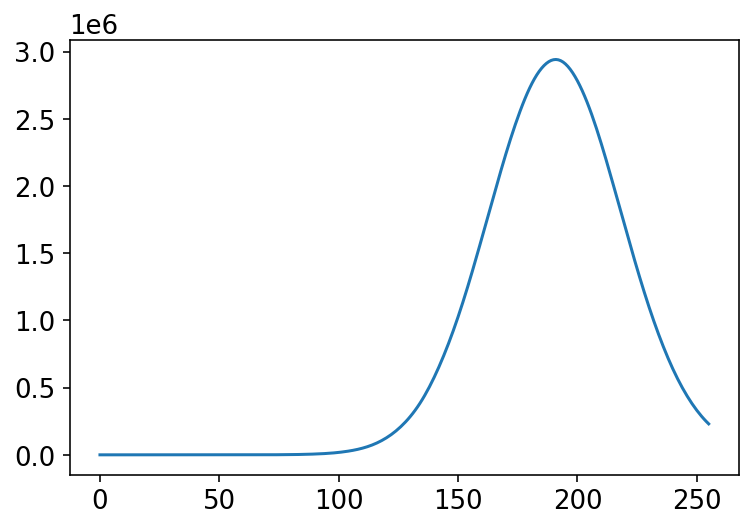

In [13]:
plt.plot(out['Ws_grid_case_A'][:,50])

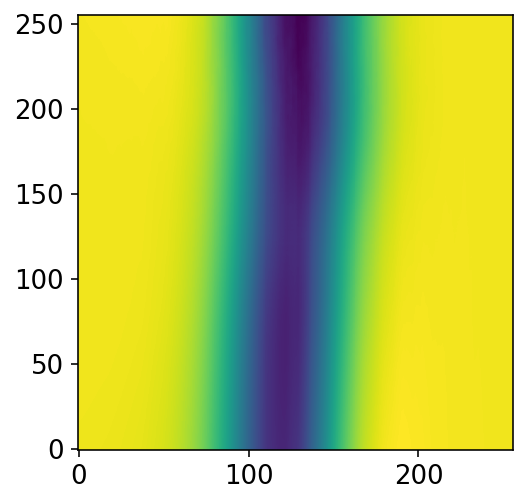

In [19]:
plt.imshow(out['Ws_grid_case_B'].T, origin = 'lower')

Text(0.5, 0.92, 'psi_s at the first step of chicane')

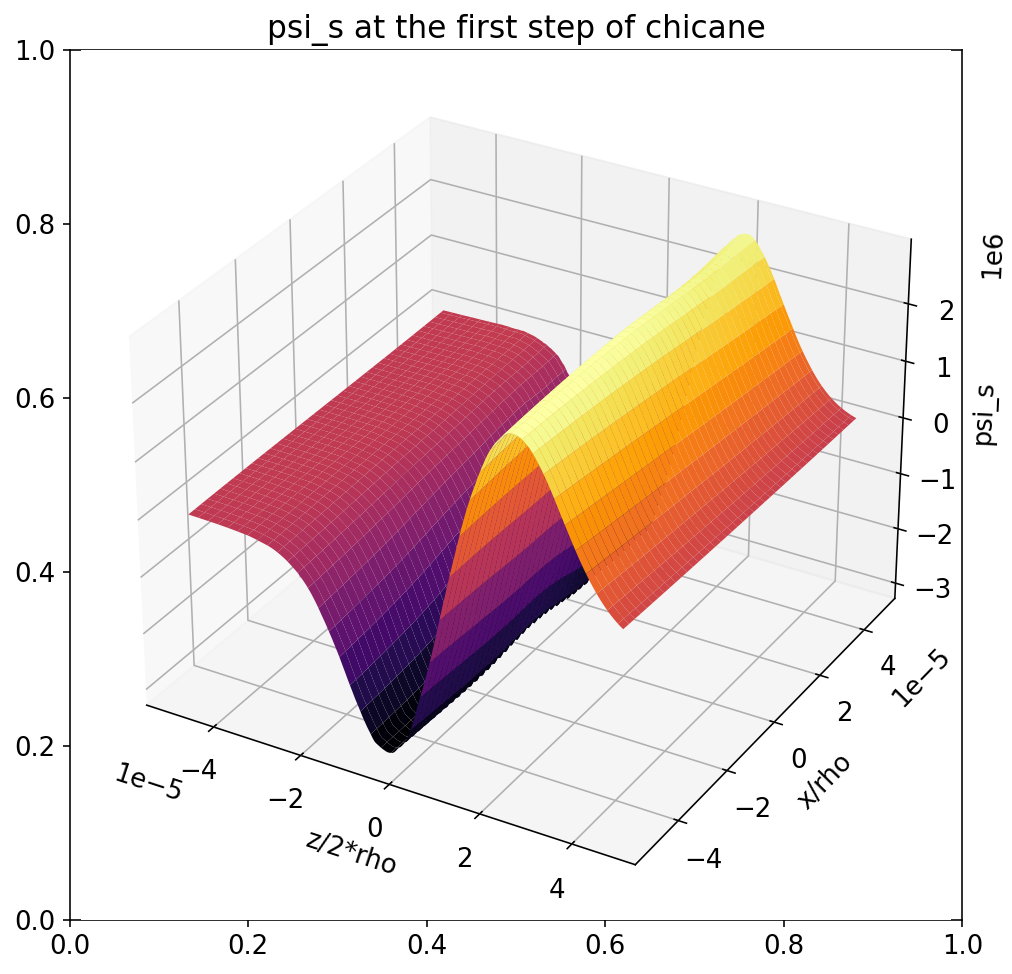

In [26]:
Z,X = np.meshgrid(out['zvec'], out['xvec'],indexing='ij') 

fig, ax = plt.subplots(figsize=(8,8))
ax = plt.axes(projection='3d')

ax.plot_surface(Z, X, out['Ws_grid'] , cmap='inferno')
ax.set_xlabel('z/2*rho')
ax.set_ylabel('x/rho')
ax.set_zlabel('psi_s')
ax.set_title('psi_s at the first step of chicane')

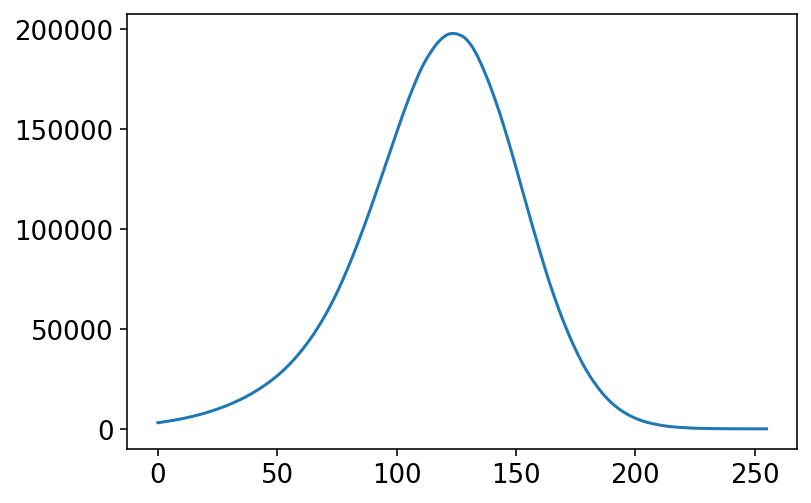

In [14]:
plt.plot(out['Wx_grid_case_B'][:,50])

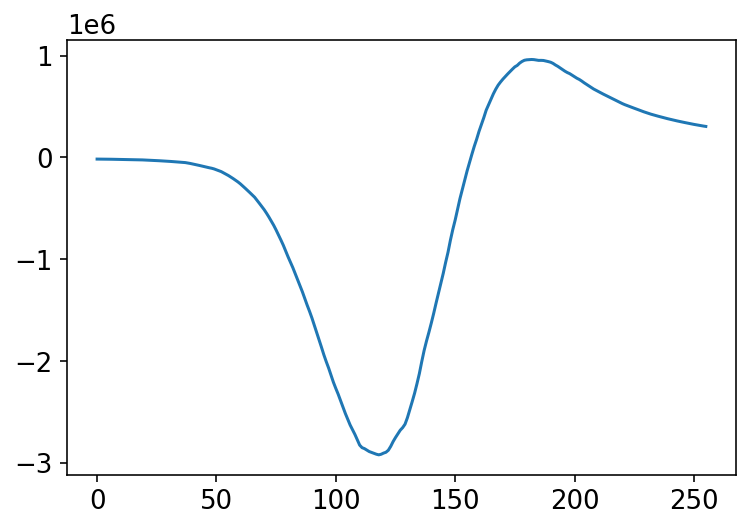

In [16]:
plt.plot(out['Ws_grid'][:,50])

In [23]:
sigma_z = 10*10**-15 * 3*10**8 
sigma_z

3.0000000000000005e-06

In [24]:
rho2 = 1/-0.067327661479468

In [25]:
L0 = (24*sigma_z*rho2**2)**(1/3)

In [26]:
L0

0.2513709840835744

In [27]:
14*10**9/0.511/10**6

27397.260273972603